# Lab 8 - Neural Networks

In this lab you'll use *neural networks* to classify images using both [scikit-learn](https://scikit-learn.org) and [PyTorch](https://pytorch.org/). PyTorch 1.9 or later is assumed to be installed. The goal is for you to see:
1. that logistic regression is a special case of neural networks; and
2. how to express the same type of network in both scikit-learn and in PyTorch, both shallow (logistic regression) and deep (several layers).

**Run the code cell below** to import the required packages.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing     # For StandardScaler
import sklearn.linear_model      # For LogisticRegression
import sklearn.neural_network    # For MLPClassifier
import torch
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)  # Annoying
np.set_printoptions(precision=3, suppress=True)  # Print as 0.001 instead of 9.876e-4

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Digit classification with neural networks in scikit-learn

Exercise 1.1&ndash;1.8 ask you to load and train a model on the classic MNIST data set. It's so classic it has its [own Wikipedia page](https://en.wikipedia.org/wiki/MNIST_database)! The MNIST data set contains 60,000 training examples and 10,000 test examples. Each example comprises a 784-dimensional feature vector $\mathbf{x}_i$ representing 28x28 grayscale image of a hand-written digit (784 = 28x28) with a label $y_i \in \{0, \ldots, 9\}$.

Since there are 60,000 training cases, the matrix of training features $\mathbf{X}$ is provided in as a 60000x784 matrix of pixel intensities. Value $X_{i,j} \in \{0, \ldots, 255\}$ represents the intensity (0=black, 255=white) of pixel number $j$ in training image $i$. Each 784-dimensional feature vector $\mathbf{x}_i$ can be reshaped into a 28x28 image as depicted below.

![image](img/mnist_data_layout.png)

**Run the code cell below** to define a function that will be useful for plotting matrices.

In [60]:
def plot_matrix_grid(V):
    """
    Given an array V containing stacked matrices, plots them in a grid layout.
    V should have shape (K,M,N) where V[k] is a matrix of shape (M,N).
    """
    assert V.ndim == 3, "Expected V to have 3 dimensions, not %d" % V.ndim
    k, m, n = V.shape
    ncol = 8                                     # At most 8 columns
    nrow = min(4, (k + ncol - 1) // ncol)        # At most 4 rows
    V = V[:nrow*ncol]                            # Focus on just the matrices we'll actually plot
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     # Guess a good figure shape based on ncol, nrow
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmin, vmax = np.percentile(V, [0.1, 99.9])   # Show the main range of values, between 0.1%-99.9%
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=vmin, vmax=vmax, cmap=plt.get_cmap('gray'))
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right

## Exercise 1.1 &ndash; Load MNIST and plot some digits

The MNIST training data has been provided to you in a file called `mnist_train.npz`. The file is located in the same directory as this Jupyter Notebook.  A `npz` file is an efficient way to store multiple Numpy arrays in a file. Use Numpy's **[load](https://docs.scipy.org/doc/numpy/reference/generated/numpy.load.html)** function to open an `npz` file. When the file is opened, you can think of the file as being a Python dictionary where you can ask for an array by its name (its 'key'). The example below shows how to open the file and list the keys:

```python
>>> with np.load("mnist_train.npz") as data:
...    print(list(data.keys()))

['X', 'y']
```
(The reason we open the file using a *with*-statement is because once the *with*-statement is complete the file ("file descriptor") is automatically closed, rather than Python trying to keep the file open. This isn't important for the lab *per se*, closing files when you're done with them is just good programming practice!)


**Write a few lines of code** to load the training data from `mnist_train.npz` and create two global vaiables *X_trn* and *y_trn* to refer to the data you loaded.

In [61]:
# Your code here. Aim for 3 lines.
with np.load('mnist_train.npz') as data:
  X_trn = data['X']
  y_trn = data['y']

**Inspect the data** by printing information about the arrays.
1. Print the shape and dtype of both your *X_trn* and *y_trn* arrays.
2. Print the first five training samples from *X_trn* and *y_trn* arrays.

Since your *X_trn* array is big, and because most of the first/last pixels in each image are 0 (black), to see any patterns in the features try printing a slice of values taken from the "middle" of each image. For example, pixels 400:415 are roughly from the middle row of each image (similar to blue rectangle in the diagram earlier), so try printing a slice of just those pixels. You should see `[  0   0   0   0   0  81 240 253 253 119  25   0   0   0   0]` printed for the first row.

In [62]:
# Your code for printing shape and dtype here. Aim for 2 lines.
print(X_trn.shape, X_trn.dtype)
print(y_trn.shape, y_trn.dtype)

# Your code for printing sample values. Aim for 2 lines.
print(X_trn[0,400:415])
print(y_trn[0])


(60000, 784) uint8
(60000,) int32
[  0   0   0   0   0  81 240 253 253 119  25   0   0   0   0]
5


**Plot a few digits** to see what they look like. Use the *plot_matrix_grid* function defined earlier. To do this, you'll need to reshape the array referred to by your *X_trn* variable so that the plotting code knows the images have shape 28x28 rather than being just 784-dimensional vectors.

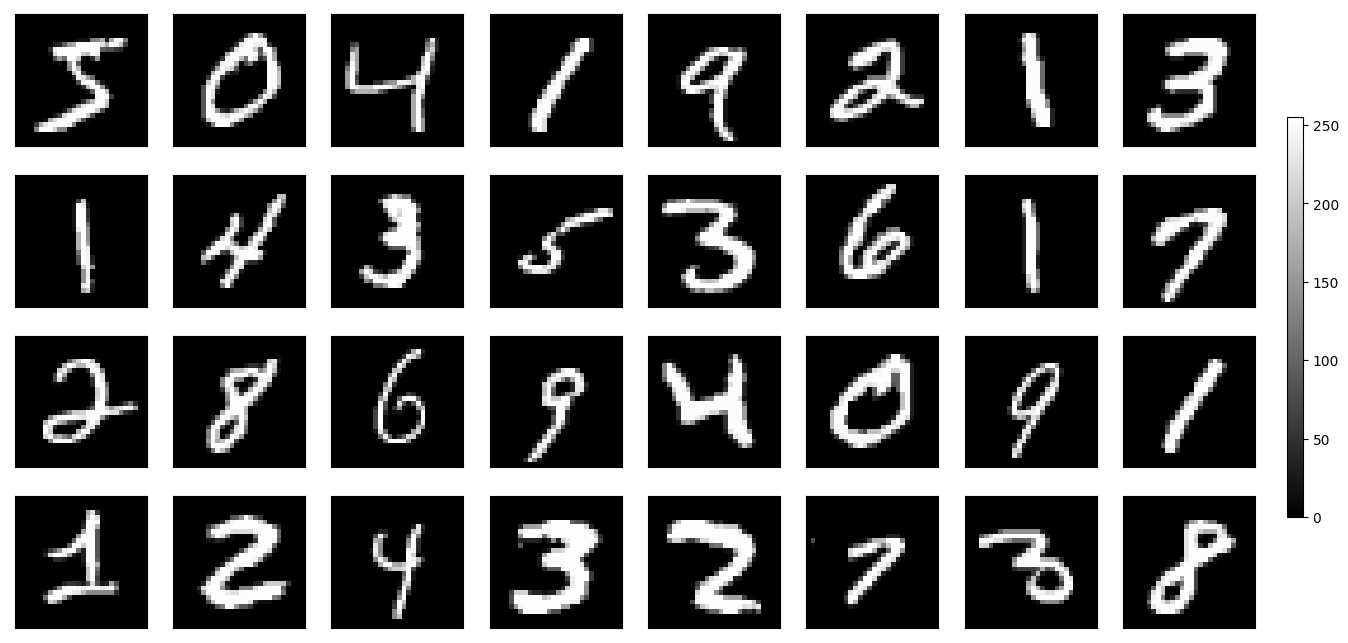

In [63]:
# Your code here. Aim for 1-2 lines.
plot_matrix_grid(X_trn.reshape(-1,28,28))

Look at the patterns you printed when inspecting the *X_trn* variable earlier, and make sure you see where they come from in the first five images plotted above.

If you want to see more of the MNIST training digits, rather than just the first few, you can try plotting different "slices" of the *X_trn* variable, such as *X_trn[100:]* to start plotting at the 101st training example. (You still have to reshape the resulting array, of course.)

Finally, **load the MNIST test data** from the file `mnist_test.npz`, just like you did for the training data. Create global variables *X_tst* and *y_tst* to refer to the arrays that you loaded. These arrays will be used to evaluate test-time accuracy later on.

In [64]:
# Your code here. Aim for 3 lines.
with np.load('mnist_test.npz') as testData:
    X_tst = testData['X']
    y_tst = testData['y']

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.2 &ndash; Preprocess the MNIST data

Certain models trained on MNIST work better when the features are normalized. Use scikit-learn to normalize the MNIST data using scaling, such as the *StandardScaler*. (You can just treat the pixels as independent features, nothing fancy.)

**Write a few lines of code** to normalize both you *X_trn* and *X_tst* variables. You can just over-write those variables with the new (normalized) feature arrays, and discard the original unscaled data.

In [65]:
# Your code here. Aim for 3-4 lines.
scalar = sklearn.preprocessing.StandardScaler()
scalar.fit(X_trn)
X_trn = scalar.transform(X_trn)
X_tst = scalar.transform(X_tst)

**Plot the rescaled training digits** using the *plot_matrix_grid* function. 

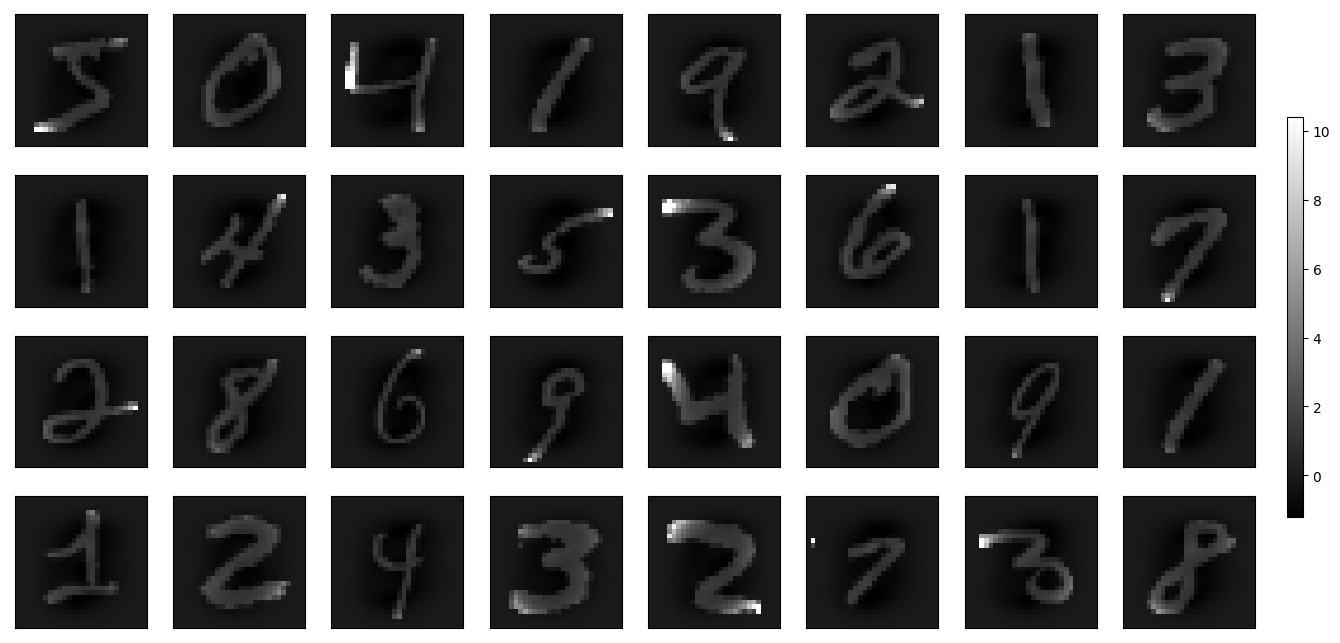

In [66]:
# Your code here. Aim for 1-2 lines.
plot_matrix_grid(X_trn.reshape(-1,28,28))

Notice that the pixels in the center tend to be scaled down more than the pixels in the periphery. *Do you understand why?*

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.3 &ndash; Train multinomial logistic regression on MNIST

Train a **[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)** object to classify MNIST digits. Use *random_state*=0 and default settings otherwise.

In [67]:
# Your code here. Aim for 2-3 lines.
logistic_reg = sklearn.linear_model.LogisticRegression(random_state=0,penalty='l2',C=.01).fit(X_trn, y_trn)

You can use the **[score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score)** method of the *LogisticRegression* object to compute the accuracy as a number in the range $[0.0, 1.0]$. Figure out how to convert that number (e.g., 0.934) into an error rate percentage (e.g., 6.6%).

**Print the training _error rate_ and testing _error rate_** of your logistic regression model on the MNIST data set. Your output should be in the form:
```
X.XX% training error
X.XX% testing error
```

In [68]:
# Your code here. Aim for 2-4 lines.
print("{:.2f}".format((1-logistic_reg.score(X_trn, y_trn))*100), '% training error')
print("{:.2f}".format((1-logistic_reg.score(X_tst, y_tst))*100), '% testing error')

6.40 % training error
7.40 % testing error


How does the testing error rate you see compare to some of the error rates mentioned on the [MNIST Wikipedia page](https://en.wikipedia.org/wiki/MNIST_database)?

**Print the predicted class probabities** of the **first five examples** in the training set. Use the *predict_proba* method of your *LogisticRegression* object. The first row of output should look something like:
```
[0.001 0.    0.    0.203 0.    0.796 0.    0.    0.    0.   ]
```
From the above probabilities we can see that the model thinks the first digit in the training set is *probably* digit "5" but *might also be* digit "3".

In [69]:
# Your code here. Aim for 1-2 lines.
print(logistic_reg.predict_proba(X_trn[:5]))

[[0.001 0.    0.001 0.231 0.    0.766 0.    0.001 0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.001 0.009 0.086 0.873 0.    0.    0.025 0.001 0.006]
 [0.    0.965 0.019 0.002 0.    0.    0.    0.    0.013 0.   ]
 [0.    0.    0.    0.    0.018 0.    0.    0.015 0.002 0.965]]


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.4 &ndash; Visualize the weights of your logistic regression model

The logisitic regression model you trained in Exercise 1.3 has a *coef_* attribute. This attribute is the array of weights $\mathbf{W}$ seen in Lecture 4 (e.g. slide 28). For the MNIST data, this matrix has shape (10, 784), because there are 10 output classes and 784=28x28 pixels. Weight $W_{k,j}$ is the weight with which of pixel $j$ contributes to output class $k$.

You are asked to visualize the weights using *plot_matrix_grid*. You may need to reshape the weight matrix to do this. The first two outputs, corresponding to predictin digit "0" and predicting digit "1" should look something like this:

<img src="img/mnist_logistic_regression_weights.png" width=180/>

Notice how the pattern for "0" is has strong negative weights in the center: that's because if there are white pixels in the center, it's unlikely that the image represents digit "0"!

<span style="color:red">If your weight patterns appear **noisier** than above, try repeating Exercise 1.3 but weaken *LogisticRegression*'s L2 penalty by a factor of 100 from its default. Take note of any change in training/test accuracy, too.</span>

**Write a few lines of code** to plot the weights and see what patterns they contain. You should see ten patterns. (Don't worry if the last few grid entries are just white boxes.)

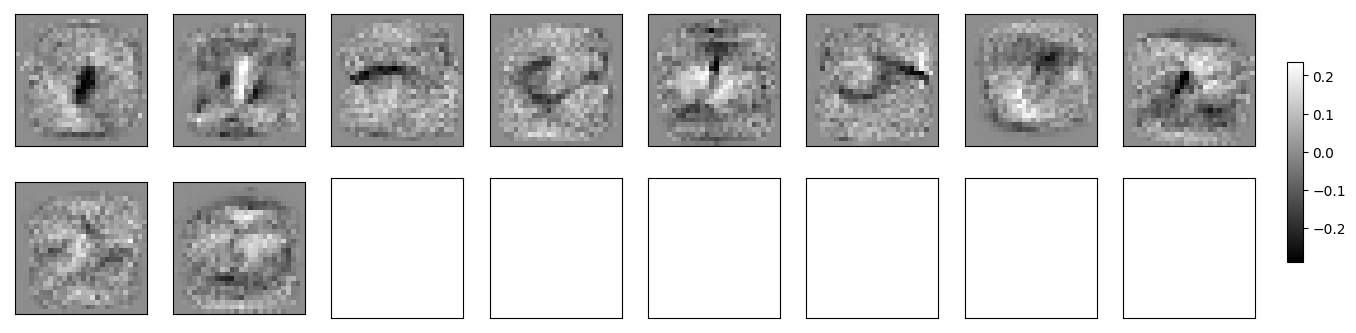

In [70]:
# Your code here. Aim for 1-2 lines.
plot_matrix_grid(logistic_reg.coef_.reshape(-1,28,28))

When an input image (of a hand-written digit) causes one of these patterns to have a large positive response (strong activation), then the corresponing class $\{0, 1, 2, \ldots, 9\}$ will be given a high probability by the final softmax operation.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.5 &ndash; Train a neural network on MNIST with *zero* hidden layers

Train a neural network on MNIST using the **[sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)** class.

A neural network has *many* more hyperparameters to configure. Configure your neural network as follows:
* Ask for *no hidden layers*. You can do this by specifying an empty tuple `()` for the *hidden_layer_sizes* argument. This will create a neural network where the 784 input features are directly 'connected' to the 10 output predictions, which in this case corresponds to the multinomial logistic regression you did in Exercise 1.4.
* Use the `sgd` solver. This means *stochastic gradient descent* that we saw in Lecture 1.
* Use a batch size of 100. This means that at each step of SGD the gradient will be computed from only 100 of the 60,000 training cases. This is also callsed a "mini-batch". The SGD algorithm works by starting with the firs 100, then the next 100, and then it gets to the last 100 in the training set it starts from the beginning again.
* Use *max_iter*=10. This causes the training to stop after SGD has passed over all 60,000 training cases exactly 10 times.
* Use *learning_rate_init*=0.01, which determines the step size for SGD once it has computed a gradient.
* Use *momentum*=0.9, which speeds up training.
* Use *random_state*=0 for reproducibility
* Use *verbose*=True to see progress printed out. Each time it prints "Iteration X" it means SGD has made another pass over all 60,000 training examples.

In [71]:
# Your code here. Aim for 1-2 lines, plus whatever line wrapping you need for arguments!
neural_network_model = sklearn.neural_network.MLPClassifier(
  hidden_layer_sizes=(),
  solver='sgd',
  batch_size=100,
  max_iter=10,
  learning_rate_init=0.01,
  momentum=0.9,
  random_state=0,verbose=True
).fit(X_trn, y_trn)


Iteration 1, loss = 0.40770306
Iteration 2, loss = 0.30859873
Iteration 3, loss = 0.29337169
Iteration 4, loss = 0.28490254
Iteration 5, loss = 0.27543585
Iteration 6, loss = 0.26958339
Iteration 7, loss = 0.26545986
Iteration 8, loss = 0.26427636
Iteration 9, loss = 0.26236903
Iteration 10, loss = 0.25963997


**Print the training error rate and test error rate** of your neural network classifier, just like you did for logistic regression.

In [72]:
# Your code here. Aim for 2-4 lines.
print("{:.2f}".format((1-neural_network_model.score(X_trn, y_trn))*100), '% training error')
print("{:.2f}".format((1-neural_network_model.score(X_tst, y_tst))*100), '% testing error')

6.84 % training error
7.68 % testing error


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.6 &ndash; Visualize the weights of a neural network (no hidden layers)

The *MLPClassifier* object has a *coefs_* attribute that works just like the *coef_* attribute that contained coefficient matrix $\mathbf{W}$ of *LogisticRegression*, except that for a neural network there are two differences:
1. *coefs_* is a *list* of coefficient matrices, so *coefs_[0]* is $\mathbf{W}^{(1)}$, the coefficient matrix of the *first layer*. Since the neural network you trained in Exercise 1.5 has no hidden layers, this
$\mathbf{W}^{(1)}$ matrix holds the same weights as the $\mathbf{W}$ matrix for LogisticRegression.
2. The weight matrix for *MLPClassifier* has a different layout: it is 784x10 rather than 10x784. Do you now how to account for this?

**Write a few lines of code** to repeat Exercise 1.4 but this time with the neural network weights.

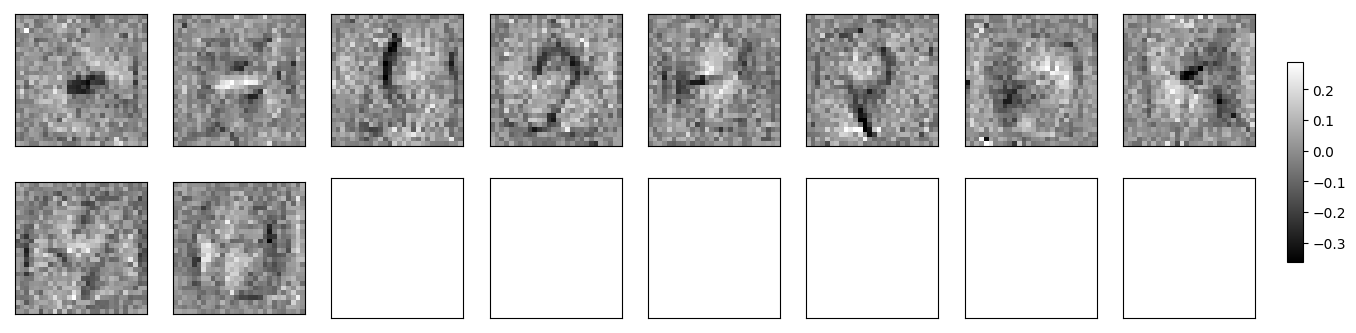

In [73]:
# Your code here. Aim for 1-2 lines.
plot_matrix_grid(neural_network_model.coefs_[0].reshape(28,28,-1).T)

If your patterns look streaky then you may need to try transposing your weight matrix to account for the different layout.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.7 &ndash; Train and visualize the weights of a neural network with 1 hidden layer

Here you're asked to train a neural network like you did in Exercise 1.5, but this time **add a hidden layer with 16 'tanh' hidden units** to your neural network. Then you'll visualize the weights of this network.

Read the documentation for **[MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)** to learn how to do specify a hidden layer. (*Note:* In Python if you want to create a *tuple* object with only one item in it, you can use *(item,)* with an extra comma, rather than *(item)*, which Python interprets to just be regular parentheses.) All the other hyperparameters can stay the same as Exercise 1.5.

**Write a few lines of code** to train a new neural network, this time with 16 *tanh* hidden units. In other words, this will be a 784-16-10 neural network where the hidden layer uses *tanh* activations. 

In [74]:
# Your code here. Aim for 1-2 lines, plus whatever line wrapping you need for arguments!
neural_network_model_1layer = sklearn.neural_network.MLPClassifier(
  hidden_layer_sizes=(16,),
  solver='sgd',
  batch_size=100,
  max_iter=10,
  learning_rate_init=0.01,
  momentum=0.9,
  random_state=0,
  verbose=True,
  activation='tanh'
  ).fit(X_trn, y_trn)

Iteration 1, loss = 0.47011299
Iteration 2, loss = 0.26978585
Iteration 3, loss = 0.23458535
Iteration 4, loss = 0.21459244
Iteration 5, loss = 0.19994936
Iteration 6, loss = 0.19026849
Iteration 7, loss = 0.18173445
Iteration 8, loss = 0.17397831
Iteration 9, loss = 0.16790016
Iteration 10, loss = 0.16357402


**Print the training error rate and test error rate** of your neural network classifier, just like you did for logistic regression. How does your error rate compare to multinomial logistic regression? (Exercises 1.3 and 1.5)

In [75]:
# Your code here. Aim for 2-4 lines.
print("{:.2f}".format((1-neural_network_model_1layer.score(X_trn, y_trn))*100), '% training error')
print("{:.2f}".format((1-neural_network_model_1layer.score(X_tst, y_tst))*100), '% testing error')

4.18 % training error
6.42 % testing error


**Plot the first-layer weights $\mathbf{W}^{(1)}$ of your neural network** using the *plot_matrix_grid* function, just in Exercise 1.6.

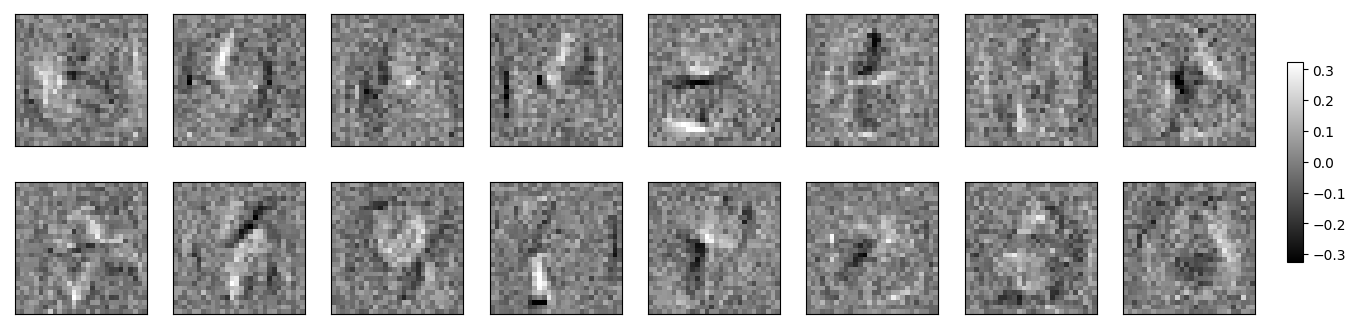

In [76]:
# Your code here. Aim for 1-2 lines.
plot_matrix_grid(neural_network_model_1layer.coefs_[0].reshape(28,28,-1).T)

Notice that there are now 16 patterns, not 10, and they no longer seem to correspond to the digits $\{0,1,\ldots,9\}$ in any particular order. *Do you understand why?*

**Plot the second-layer weights $\mathbf{W}^{(2)}$ of your neural network** using the *plot_matrix_grid* function. 

However, this time if you inspect the shape of the second weight matrix, *coefs_[1]*, you'll see that it has shape $(16, 10)$, and so it cannot be reshaped into a 28x28 pattern. In fact the second layer has only dimension: the "hidden layer" is just a vector of 16 values (the 16 tanh-transformed activations of the first-layer patterns). Each of the 10 output units has 16 weights contributing to it, rather than 784 weights like in Exercise 1.6.

Figure out how to reshape the weight matrix so that when you call *plot_matrix_grid* you see a grid of 1x16 weight vectors, like the two examples below:
![image](img/mnist_mlp_hidden_weights.png)

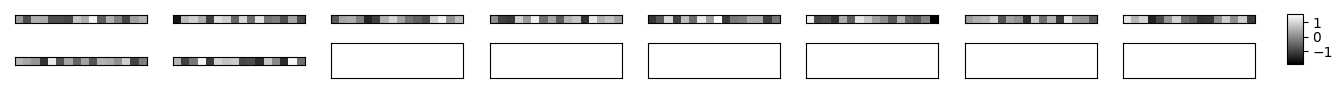

In [77]:
# Your code here. Aim for 1-2 lines.
plot_matrix_grid(neural_network_model_1layer.coefs_[1].reshape(-1,1,16))


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 1.8 &ndash; Train a neural network with lots of hidden units

Repeat Exercise 1.7 but with two hidden layers having **100 and 50 hidden units** respectively. This time use **_relu_ activations**. All other hyperparameters can stay the same.

**Write a few lines of code** to train the model here.

In [78]:
# Your code here. Aim for 1-2 lines, plus whatever line wrapping you need for arguments!
nn_model_multilayer = sklearn.neural_network.MLPClassifier(
  hidden_layer_sizes=(100,50),
  solver='sgd',
  batch_size=100,
  max_iter=10,
  learning_rate_init=0.01,
  momentum=0.9,
  random_state=0,
  verbose=True
  ).fit(X_trn, y_trn)

Iteration 1, loss = 0.33306221
Iteration 2, loss = 0.13727616
Iteration 3, loss = 0.09523979
Iteration 4, loss = 0.07193538
Iteration 5, loss = 0.05528783
Iteration 6, loss = 0.04298481
Iteration 7, loss = 0.03308290
Iteration 8, loss = 0.02760081
Iteration 9, loss = 0.02298517
Iteration 10, loss = 0.01933388


**Print the training and testing error rates** here. *How do they compare to earlier models?*

In [79]:
# Your code here. Aim for 2-4 lines.
print("{:.2f}".format((1-nn_model_multilayer.score(X_trn, y_trn))*100), '% training error')
print("{:.2f}".format((1-nn_model_multilayer.score(X_tst, y_tst))*100), '% testing error')

0.22 % training error
2.78 % testing error


**Plot the first-layer weights $\mathbf{W}^{(1)}$ of your neural network** here. *Are the pattern detectors here qualitatively different than for earlier models?*

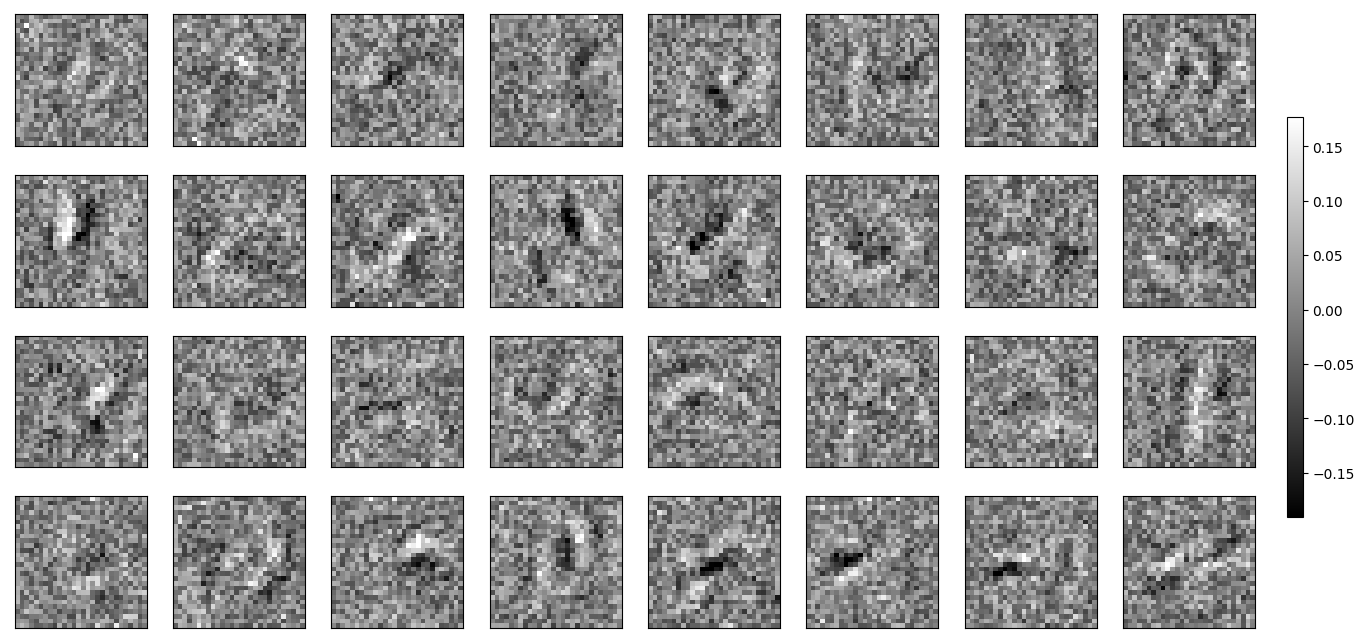

In [80]:
# Your code here. Aim for 1-2 lines.
plot_matrix_grid(nn_model_multilayer.coefs_[0].reshape(28,28,-1).T)


Don't bother plotting the 2nd and 3rd layer weights, they are high-dimensional and hard to interpret.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 2. Neural networks in PyTorch

Exercise 2.1&ndash;2.3 ask you to train a simple neural network in **[PyTorch](https://pytorch.org/docs/stable/index.html)**. Here you'll use PyTorch to train an MNIST classifier using the same MNIST data that you already preprocess in Part 1. The goal is just to get you familiar with PyTorch basics and how they compare to scikit-learn.

PyTorch is a deep learning framework like TensorFlow. PyTorch tends to be popular with deep learning researchers because it's very flexible for trying new ideas. TensorFlow is also flexible but is designed in such a way that it's more popular for companies trying to deploy high-performance models (in the cloud etc). Both can be used for research, of course! 

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 2.1 &ndash; Convert MNIST from Numpy arrays to PyTorch tensors

PyTorch has its own Numpy-like array class, called *Tensor*. In order to train a PyTorch model, you must first convert the Numpy arrays. PyTorch understands Numpy arrays, so this is easy. The only tricky part is that, in order to be fast and not waste memory, PyTorch tends to be more picky about the *dtype* of the arrays you give it.

**Write a few lines of code** to create four global variables: *X_trn_torch, y_trn_torch, X_tst_torch, y_tst_torch* that are PyTorch versions of your preprocessed MNIST training data from Part 1. The *X* tensors should have *dtype* float32, and the *y* tensors should have *dtype* int64.

In [81]:
# Your code here. Aim for 2-4 lines.
X_trn_torch = torch.from_numpy(X_trn.astype('float32'))
y_trn_torch = torch.from_numpy(y_trn.astype('int64'))
X_tst_torch = torch.from_numpy(X_tst.astype('float32'))
y_tst_torch = torch.from_numpy(y_tst.astype('int64'))

**Run the code cell below** to check your answer.

In [82]:
assert 'X_trn_torch' in globals(), "You didn't declare a X_trn_torch variable!"
assert 'y_trn_torch' in globals(), "You didn't declare a y_trn_torch variable!"
assert 'X_tst_torch' in globals(), "You didn't declare a X_tst_torch variable!"
assert 'y_tst_torch' in globals(), "You didn't declare a y_tst_torch variable!"
assert isinstance(X_trn_torch, torch.Tensor)
assert isinstance(y_trn_torch, torch.Tensor)
assert isinstance(X_tst_torch, torch.Tensor)
assert isinstance(y_tst_torch, torch.Tensor)
assert X_trn_torch.dtype == torch.float32
assert y_trn_torch.dtype == torch.int64
assert X_trn_torch.shape == (60000,784)
assert y_trn_torch.shape == (60000,)
assert X_tst_torch.dtype == torch.float32
assert y_tst_torch.dtype == torch.int64
assert X_tst_torch.shape == (10000,784)
assert y_tst_torch.shape == (10000,)
print("Correct!")

Correct!


<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 2.2 &ndash; Train a PyTorch neural network *without* hidden layers

This exercise only asks you to **run existing code** so that you learn how PyTorch works. The code in this cell defines a simple logistic model, and then you are asked to modify the code to add hidden layers to the network.

Useful documentation for understanding the code that you see:
* **[torch.nn](https://pytorch.org/docs/stable/nn.html)** (neural network)
* **[torch.optim](https://pytorch.org/docs/stable/optim.html)** (optimizers such as SGD)

Here are some comments to help you understand the "starter code" below:

* A neural network is a sequence of non-linear transformations, so PyTorch provides a **[Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)** class that accepts a list of desired transformations.

* In a standard neural network, the transformations are just linear, i.e. $\mathbf{Wx}+\mathbf{b}$, and in PyTorch this is implemented by a **[Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)** class where constructing one of these objects with *Linear(D, M)* tells the new object that it should be expecting an *D*-dimensional input and transform it into a *M*-dimensional output. To do this, the *Linear* object will create its own parameter matrix $\mathbf{W} \in \mathbb{R}^{M\times D}$ and bias vector $\mathbf{b} \in \mathbb{R}^M$.

* In PyTorch, the **[CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)** class conveniently combines applying a softmax and then computing the negative log likelihood, so you don't explicitly apply softmax while training. Once you have a *CrossEntropyLoss* object, you can call it with your predictions and targets (both vectors), and it will compute the negative log likelihood, which is just one number (a scalar).
 


**Run the code cell below** to define a simple 784-10 neural network (i.e. logistic regression).

In [83]:
torch.manual_seed(0) # Ensure model weights initialized with same random numbers

# Create an object that holds a sequence of layers and activation functions
model = torch.nn.Sequential(
    torch.nn.Linear(28*28, 10),   # Applies Wx+b from 784 dimensions down to 10
)

**Run the code cell below** to define some objects and variables needed for training the neural network.

In [84]:
# Create an object that can compute "negative log likelihood of a softmax"
loss = torch.nn.CrossEntropyLoss()

# Use stochastic gradient descent to train the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Use 100 training samples at a time to compute the gradient.
batch_size = 100

# Make 10 passes over the training data, each time using batch_size samples to compute gradient
num_epoch = 10
next_epoch = 1

**Run the code cell below** to train the neural network using stochastic gradient descent (SGD). *Note that if you re-run this code cell multiple times it will "continue" training from the current parameters, and if you want to "reset" the model you need to re-run the earlier code cell that defined the model!*

In [85]:
for epoch in range(next_epoch, next_epoch+num_epoch):
    
    # Make an entire pass (an 'epoch') over the training data in batch_size chunks
    for i in range(0, len(X_trn), batch_size):        
        X = X_trn_torch[i:i+batch_size]     # Slice out a mini-batch of features
        y = y_trn_torch[i:i+batch_size]     # Slice out a mini-batch of targets

        y_pred = model(X)                   # Make predictions (final-layer activations)
        l = loss(y_pred, y)                 # Compute loss with respect to predictions
        
        model.zero_grad()                   # Reset all gradient accumulators to zero (PyTorch thing)
        l.backward()                        # Compute gradient of loss wrt all parameters (backprop!)
        optimizer.step()                    # Use the gradients to take a step with SGD.
        
    print("Epoch %2d: loss on final training batch: %.4f" % (epoch, l.item()))
    
print("Epoch %2d: loss on test set: %.4f" % (epoch, loss(model(X_tst_torch), y_tst_torch)))
next_epoch = epoch+1

Epoch  1: loss on final training batch: 0.7097
Epoch  2: loss on final training batch: 0.8752
Epoch  3: loss on final training batch: 0.3313
Epoch  4: loss on final training batch: 0.3312
Epoch  5: loss on final training batch: 0.3239
Epoch  6: loss on final training batch: 0.3168
Epoch  7: loss on final training batch: 0.3128
Epoch  8: loss on final training batch: 0.3074
Epoch  9: loss on final training batch: 0.3044
Epoch 10: loss on final training batch: 0.2990
Epoch 10: loss on test set: 0.3206


**Run the code cell below** to retrieve the PyTorch model's parameters, convert them back to Numpy, and plot them like before.

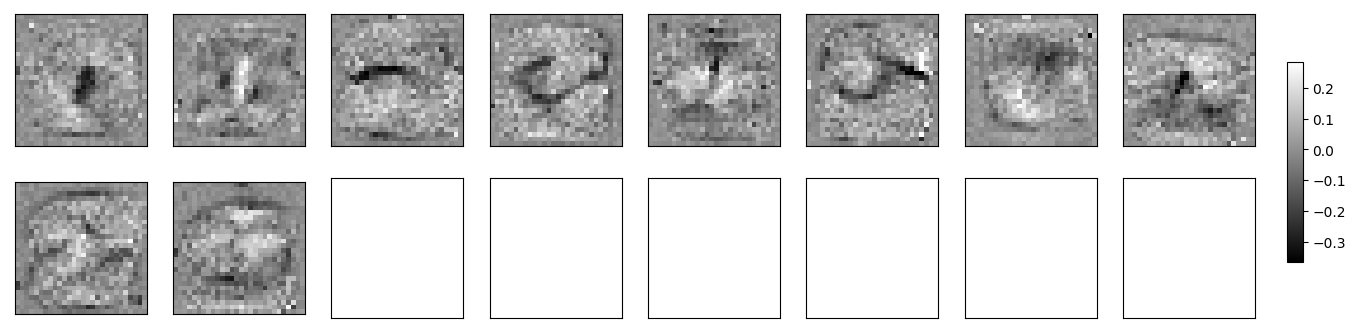

In [86]:
W, b, *_ = model.parameters()
W = W.detach().numpy()
plot_matrix_grid(W.reshape(-1, 28, 28))

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>

## Exericise 2.3 &ndash; Train a PyTorch neural network *with* hidden layers

Using Exercise 2.2 as a starting point, write new code to **implement a 784-100-50-10 neural network** with **_relu_ activations** just like you did in Exercise 1.8, but now implemented with PyTorch.

To do this, you will need to:
1. Create a new *model* object that has more sequential steps to it, including the *Linear* and **[ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)** objects.
2. Create a new *optimizer* object that knows about your new model's parameters.

If you succeed, you should be able to get the training loss to go to zero, especially if you run the training loop code cell extra times (i.e. more than 10 epochs total). *But what happens with the test set loss, as you continue training?*

We will do more PyTorch in the next lab, with convolutional neural networks.

In [87]:
# Your PyTorch to create the model and optimizer here. 
torch.manual_seed(0)

model = torch.nn.Sequential(
    torch.nn.Linear(28*28, 100),
    torch.nn.ReLU(), 
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(), 
    torch.nn.Linear(50, 10),
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [94]:

# Your PyTorch training loop here.

# Use 100 training samples at a time to compute the gradient.
batch_size = 100

# Make 10 passes over the training data, each time using batch_size samples to compute gradient
num_epoch = 100
next_epoch = 1

for epoch in range(next_epoch, next_epoch+num_epoch):
    
    for i in range(0, len(X_trn), batch_size):        
        X = X_trn_torch[i:i+batch_size]     
        y = y_trn_torch[i:i+batch_size]     

        y_pred = model(X)                  
        l = loss(y_pred, y)                 
        
        model.zero_grad()                   
        l.backward()                        
        optimizer.step()               
        
    print("Epoch %2d: loss on final training batch: %.4f" % (epoch, l.item()))
    
print("Epoch %2d: loss on test set: %.4f" % (epoch, loss(model(X_tst_torch), y_tst_torch)))
next_epoch = epoch+1

Epoch  1: loss on final training batch: 0.0002
Epoch  2: loss on final training batch: 0.0002
Epoch  3: loss on final training batch: 0.0002
Epoch  4: loss on final training batch: 0.0002
Epoch  5: loss on final training batch: 0.0002
Epoch  6: loss on final training batch: 0.0002
Epoch  7: loss on final training batch: 0.0002
Epoch  8: loss on final training batch: 0.0002
Epoch  9: loss on final training batch: 0.0002
Epoch 10: loss on final training batch: 0.0002
Epoch 11: loss on final training batch: 0.0002
Epoch 12: loss on final training batch: 0.0002
Epoch 13: loss on final training batch: 0.0002
Epoch 14: loss on final training batch: 0.0002
Epoch 15: loss on final training batch: 0.0002
Epoch 16: loss on final training batch: 0.0001
Epoch 17: loss on final training batch: 0.0001
Epoch 18: loss on final training batch: 0.0001
Epoch 19: loss on final training batch: 0.0001
Epoch 20: loss on final training batch: 0.0001
Epoch 21: loss on final training batch: 0.0001
Epoch 22: los

KeyboardInterrupt: 

Finally, use the *named_parameters* method, available on all PyTorch [*Module*](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) objects, to print the name and shape of each parameter tensor in the neural network. Your output should look something like:
```
0.weight  torch.Size([?])
0.bias    torch.Size([?])
...
```

In [89]:
# Your code here. Aim for 2-3 lines.
for i in range(4):
    for name,param in model[i].named_parameters():
        print (i,".",name,'\t',param.size(),sep="")

0.weight	torch.Size([100, 784])
0.bias	torch.Size([100])
2.weight	torch.Size([50, 100])
2.bias	torch.Size([50])
